- generate forest raster
- generate non forest mask
- generate zeros raster of same size, burnyear
- iterate through burns
  - determine ellipsoid dims (area from csv, random ratio between say .2 and .6, random orientation)
  - apply ellipsoid to random location with forest
  - determine area burned
  - while area burned < target,
     dilate ellipsoid, determine area burned
     https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.ndimage.morphology.binary_dilation.html
  - don't step up more than x% over target burned area
  - note burned area by year in burnyear
  - expand non-burnable mask by burnyear < n years ago


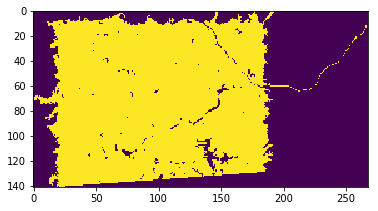

In [99]:
%matplotlib inline

import rasterio
from rasterio import features
import fiona
from affine import Affine

import csv
import random
from math import ceil
from math import pi
from math import radians
from math import sqrt

import pandas
import numpy.ma as ma
import numpy as np
from matplotlib import pyplot
from skimage.draw import ellipse


# fires can have secondary axis length between .2 and .8 of primary axis
FIRE_AXIS_MAX_PCT = 80
FIRE_AXIS_MIN_PCT = 20
TEST_CSV = "/Users/snorris/projects/cat/2019_wildfire/futurefire/data/lowscenario.csv"


def ellipse_axes(area, ratio):
    """Calculate the lengths of an ellipse's axes based on area and ratio
    """
    # Area = pi * a * b
    a = sqrt((area / pi) / ratio)
    return (a, a * ratio)


# get default transform
with rasterio.open("/Users/snorris/projects/cat/2019_wildfire/futurefire/data/isbc.tif") as like_rast:
    crs = like_rast.crs
    res = like_rast.res
    transform = like_rast.transform

# read inventory data
with fiona.open("/Users/snorris/projects/cat/2019_wildfire/futurefire/tests/data/inventory.shp") as src:
    bounds = src.bounds
    width = max(int(ceil((bounds[2] - bounds[0]) /
                                float(res[0]))), 1)
    height = max(int(ceil((bounds[3] - bounds[1]) /
                 float(res[1]))), 1)
    kwargs = {
        'count': 1,
        'crs': crs,
        'width': width,
        'height': height,
        'transform': Affine(res[0], 0, bounds[0], 0, -res[1],
                            bounds[3])
    }
    # if there is a leading species, call the cell forest
    geometries = [(s["geometry"], 1) for s in src if s['properties']['ldspp']]
    forest = features.rasterize(
        geometries,
        out_shape=(kwargs['height'], kwargs['width']),
        transform=kwargs['transform']
    )

pyplot.imshow(forest)
pyplot.show()


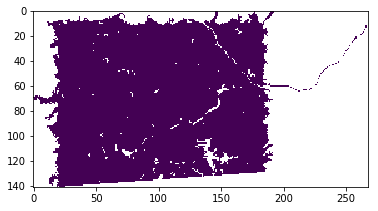

In [100]:
forest_mask = ma.masked_equal(forest, 0)
pyplot.imshow(forest_mask)
pyplot.show()


In [101]:
# read scenario csv
firelist = pandas.read_csv(TEST_CSV)

# test with a few rows
firelist = firelist[:10]
firelist.head()


,Unnamed: 0,year,region,runid,area
0,1,2020,Coast,1,864.140684
1,2,2020,Coast,2,1418.700822
2,3,2020,Coast,3,265.954884
3,4,2020,Coast,3,521.975750
4,5,2020,Coast,3,510.860470


In [237]:
def burn_ellipse(r, c, area, year, burn_image):
    """
    Given row (y), column (x) and area to burn, burn the year value 
    into provided image as a randomly oriented ellipse with supplied area
    """
    # create a set of valid ratios of minor axis to major axis length (eg 70%)
    ratios = [round((ratio * .01), 2) for ratio in range(FIRE_AXIS_MIN_PCT, FIRE_AXIS_MAX_PCT, 5)]
    
    # Set the ellipse rotation (rotation) in range (-PI, PI) 
    # in contra clock wise direction, so PI/2 degree means swap ellipse axis
    rotations = [radians(deg) for deg in range(1, 360, 1)]

    # randomly determine axes lengths
    a, b = ellipse_axes(area, ratio=random.choice(ratios))
    
    # create ellipse
    rr, cc = ellipse(r, c, a, b, burn_image.shape, rotation=random.choice(rotations))
        
    return (rr, cc)
    

In [238]:
def randomize(forest):
    """
    Given a 2d array where 0=non-forest and 1=forest, 
    generate a randomly sorted list of 1-d indexes that are forested locations
    """
    # flatten the forest because we need a 1d array 
    flat_forest = forest.flatten()
    # generate an array of index values for flattened mask, and return only values that are forest
    idx = np.arange(len(flat_forest))[flat_forest > 0]
    # shuffle the index and return
    np.random.shuffle(idx)
    return idx
    
def check_unburned(idx_position, forest_idx, burned, year, regen):
    """
    Check that the given index (ignition point) is not already burned.
    If it is, try the next until we find something that is not.
    """
    burns = burned.flatten()
    while burns[forest_idx[idx_position]] > (year - regen):
        idx_position += 1
        if idx_position > len(forest_idx):
            raise ValueError('no unburned area found')
    return idx_position

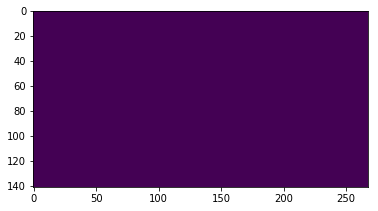

In [279]:
# initialize an image to hold all fires
# this is the same as the masked forest image
burned = np.zeros(shape=forest.shape)

runs = list(fires.runid.unique())
regions = list(fires.region.unique())
years = list(fires.year.unique())


def apply_fires(fires, run, region, year, n=None):
    """Burn all fires for given run, region, year combination"""

    # get list of burn areas
    to_burn = fires[(fires['runid'] == run) & (fires['year'] == year) & (fires['region'] == region)]
    if n:
        to_burn = to_burn[:n]
    # generate a shuffled list all forested location indexes
    forest_idx = randomize(forest)

    # start from the top of the shuffled list
    idx_position = 0
    
    # apply burns one by one
    for area in [round(a) for a in list(to_burn.area)]:
        
        # make sure ignition point is not already burned within < regen period
        idx_position = check_unburned(idx_position, forest_idx, burned, year, 20)

        # convert flattened unburned forest index position into row/column
        y, x = np.unravel_index(forest_idx[idx_position], burned.shape)
                
        target_area = area
        ellipse_area = area
        target_area_met = False
        iteration = 1
        ellipse_list = []
        # The ellipse center is forested but may cover many non-forested areas
        # Expand the ellipse until it burns enough forested area to meet target
        while not target_area_met:
            # get ellipse
            rr, cc = burn_ellipse(y, x, ellipse_area, year, burned)
            # calc burned area
            burned_forest_area = forest[rr, cc].sum()
            # record the values
            ellipse_list.append([iteration, (rr, cc), burned_forest_area])
            # stop if target met
            if burned_forest_area >= target_area:
                target_area_met = True
            # otherwise increment size of ellipse
            else:
                pct_diff = (target_area - burned_forest_area) / target_area
                ellipse_area = ellipse_area * (1 + pct_diff)

        # burn the value of current year into the burn image
        #burned[rr, cc] = year



run = 3
region = "Coast"
year = 2020
apply_fires(fires, run, region, year, n=3)

pyplot.imshow(burned)
pyplot.show()

In [277]:
area = 800

# generate a shuffled list all forested location indexes
forest_idx = randomize(forest)

# start from the top of the shuffled list
idx_position = 0

# make sure ignition point is not already burned within < regen period
idx_position = check_unburned(idx_position, forest_idx, burned, year, 20)

# convert flattened unburned forest index position into row/column
y, x = np.unravel_index(forest_idx[idx_position], burned.shape)

target_area = area
ellipse_area = area
target_area_met = False
iteration = 1
ellipse_list = []
increment = .01 * target_area  # increment by 1% of target area

# The ellipse center is forested but may cover many non-forested areas
# Expand the ellipse until it burns enough forested area to meet target
while not target_area_met:
    # get ellipse
    rr, cc = burn_ellipse(y, x, ellipse_area, year, burned)
    # calc burned area
    burned_forest_area = forest[rr, cc].sum()
    # record the values
    ellipse_list.append([iteration, (rr, cc), burned_forest_area])
    # stop if target met
    if burned_forest_area >= target_area:
        target_area_met = True
    # otherwise increment size of ellipse
    else:
        pct_diff = (target_area - burned_forest_area) / target_area
        ellipse_area = ellipse_area + increment
# choose the best result
# easy when it is exact or the first result
if len(ellise_list) == 1:
    burn = ellipse_list[0]
else:
# otherwise pick the last two and find which is closer to the target
    

In [278]:
[e[2] for e in ellipse_list]

[793, 799, 811]

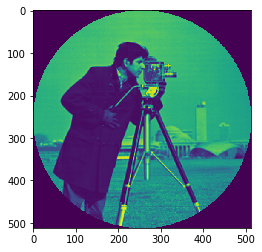

In [285]:
import matplotlib.pyplot as plt
from skimage import data
from skimage.draw import random_shapes

camera = data.camera()

# We can visualize the images.
nrows, ncols = camera.shape
row, col = np.ogrid[:nrows, :ncols]
cnt_row, cnt_col = nrows / 2, ncols / 2
outer_disk_mask = ((row - cnt_row)**2 + (col - cnt_col)**2 >
                    (nrows / 2)**2)
camera[outer_disk_mask] = 0

# Let's start simple and generate a 128x128 image
# with a single grayscale rectangle.
result = random_shapes((128, 128), max_shapes=1, shape='rectangle',
                       multichannel=False)


pyplot.imshow(camera)
pyplot.show()